In [31]:
%pip install -q pandas networkx scikit-learn pymongo nltk pydantic uvicorn fastapi seaborn requests

Note: you may need to restart the kernel to use updated packages.


In [10]:
from pathlib import Path
import sys

# add the repo root (…/service) so `models` is importable
ROOT = Path("..").resolve()        # points to service/
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from models.graph import company_affiliation

In [20]:
import json
from pathlib import Path
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

BASE_DIR = Path("..")          # adjust if notebook is somewhere else
PEOPLE_PATH = BASE_DIR / "data" / "people.json"

with PEOPLE_PATH.open("r", encoding="utf-8") as f:
    people = json.load(f)

len(people), people[0].keys()

(148,
 dict_keys(['_id', 'name', 'company', 'role', 'schools', 'skills', 'keywords', 'seniority', 'connections']))

In [21]:
def get_list(x, key):
    v = x.get(key, [])
    if isinstance(v, list):
        return v
    return []

rows = []
for p in people:
    _id = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    rows.append({
        "id": _id,
        "name": p.get("name", ""),
        "company": p.get("company", ""),
        "role": p.get("role", ""),
        "seniority": p.get("seniority", "Other"),
        "n_schools": len(get_list(p, "schools")),
        "n_skills": len(get_list(p, "skills")),
        "n_keywords": len(get_list(p, "keywords")),
        "n_connections": len(p.get("connections", [])),
    })

df = pd.DataFrame(rows)
df.head()

,id,name,company,role,seniority,n_schools,n_skills,n_keywords,n_connections
0,travis_liu,Travis Liu,RBC,Software Engineer in Test,Other,1,18,5,3
1,kristina_z_16412b2a7,Kristina Zaporozhets,Scotiabank,Global Analytics and Financial Engineer Intern,Student/Intern,1,9,5,0
2,ngoc_vien_do_991273gs1,Ngoc Vien Do,,Software Developer,Entry,1,6,0,0
3,andrewnt219,Andrew Nguyen,KPMG Canada,Software Engineer,Entry,1,10,5,0
4,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",KPMG Canada,Partner,Manager+,1,10,5,0


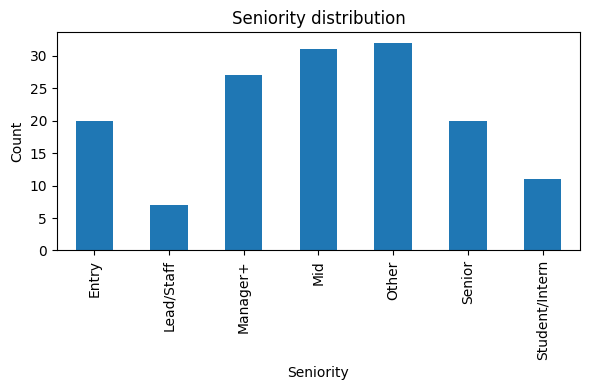

In [22]:
plt.figure(figsize=(6,4))
df["seniority"].value_counts().sort_index().plot(kind="bar")
plt.title("Seniority distribution")
plt.xlabel("Seniority")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [15]:
rows = []
for u, v, data in G.edges(data=True):
    rows.append({
        "u": u,
        "v": v,
        "u_name": G.nodes[u]["name"],
        "v_name": G.nodes[v]["name"],
        "skill_overlap": data["skill_overlap"],
        "relationship_strength": data["relationship_strength"],
        "company_affinity": data["company_affinity"],
        "edge_weight": data["weight"],
    })

edges_df = pd.DataFrame(rows)
edges_df.head()

,u,v,u_name,v_name,skill_overlap,relationship_strength,company_affinity,edge_weight
0,travis_liu,andrewnt219,Travis Liu,Andrew Nguyen,1,0.0,0.0,0.5
1,travis_liu,minhduc_hoang,Travis Liu,Minh Duc Hoang,1,0.0,0.0,0.5
2,travis_liu,khoivu,Travis Liu,Khoi Vu,2,0.0,0.0,1.0
3,travis_liu,aryank1511,Travis Liu,Aryan K.,1,0.0,0.0,0.5
4,travis_liu,angelshinh,Travis Liu,Angel Shinh,1,0.0,0.0,0.5


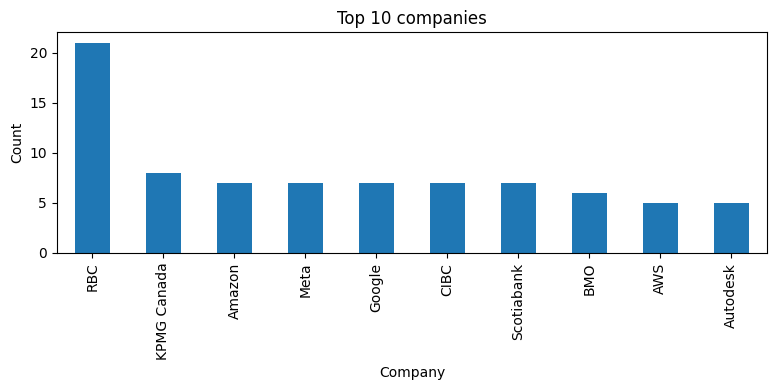

In [23]:
plt.figure(figsize=(8,4))
df["company"].replace("", "Unknown").value_counts().head(10).plot(kind="bar")
plt.title("Top 10 companies")
plt.xlabel("Company")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

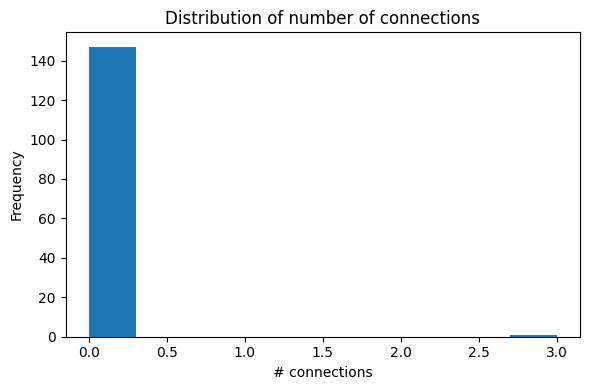

,name,n_connections
0,Travis Liu,3
93,Bilal Ahmed,0
95,Victor Huang,0
96,Megan O’Connor,0
97,Arnav Shah,0
98,Julia Santos,0
99,David Park,0
100,Sarah Thompson,0
101,Omar El-Sayed,0
102,Priyanka Desai,0


In [24]:
plt.figure(figsize=(6,4))
df["n_connections"].plot(kind="hist", bins=10)
plt.title("Distribution of number of connections")
plt.xlabel("# connections")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df[["name", "n_connections"]].sort_values("n_connections", ascending=False).head(10)

In [25]:
G = nx.Graph()

# Add nodes with attributes
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    G.add_node(
        pid,
        name=p.get("name", ""),
        company=p.get("company", ""),
        seniority=p.get("seniority", "Other"),
    )

# Add edges from connections field
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    conns = p.get("connections", []) or []
    for c in conns:
        tgt = c.get("to")
        if not tgt:
            continue
        strength = c.get("strength", 1.0)
        # Undirected graph; you can switch to DiGraph if you want direction
        G.add_edge(pid, tgt, weight=strength, tags=tuple(c.get("tags", [])))

G.number_of_nodes(), G.number_of_edges()

(151, 3)

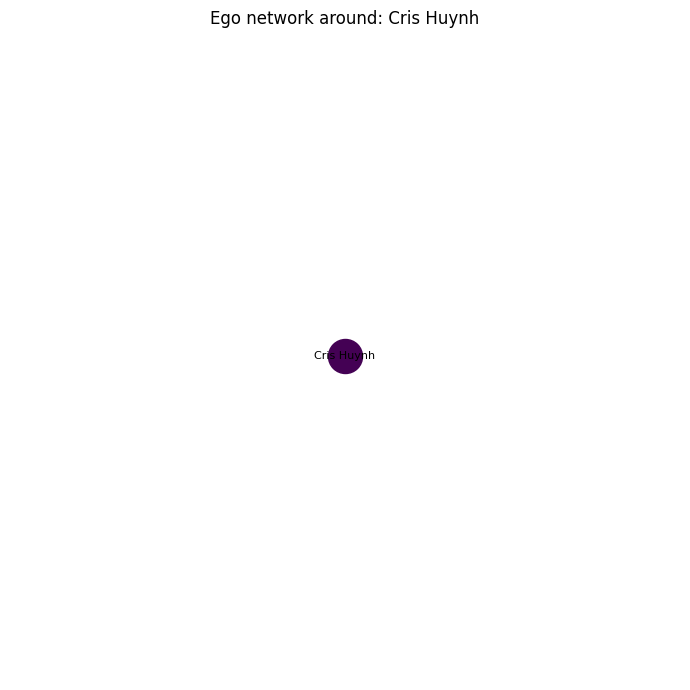

In [26]:
center_id = "cris_huynh_2a52b5274"  # change to whoever you want

# Ego network radius=1 (direct neighbors)
ego = nx.ego_graph(G, center_id, radius=1)

plt.figure(figsize=(7,7))
pos = nx.spring_layout(ego, seed=42)

# Node colors by company (just simple mapping)
companies = [G.nodes[n].get("company", "") for n in ego.nodes()]
unique_companies = {c: i for i, c in enumerate(sorted(set(companies)))}
node_colors = [unique_companies[c] for c in companies]

nx.draw_networkx_nodes(ego, pos, node_size=600, node_color=node_colors)
nx.draw_networkx_edges(ego, pos, alpha=0.4)
nx.draw_networkx_labels(
    ego, pos,
    labels={n: G.nodes[n].get("name", n) for n in ego.nodes()},
    font_size=8
)

plt.title(f"Ego network around: {G.nodes[center_id]['name']}")
plt.axis("off")
plt.tight_layout()
plt.show()

## Visualize Connection

In [27]:
df_corr = df[["n_skills", "n_keywords", "n_connections"]]
df_corr.corr()

,n_skills,n_keywords,n_connections
n_skills,1.000000,0.331634,0.440323
n_keywords,0.331634,1.000000,0.030935
n_connections,0.440323,0.030935,1.000000


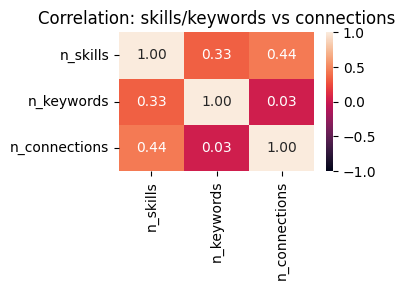

In [32]:
import seaborn as sns

plt.figure(figsize=(4,3))
sns.heatmap(df_corr.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation: skills/keywords vs connections")
plt.tight_layout()
plt.show()

## Network Plot

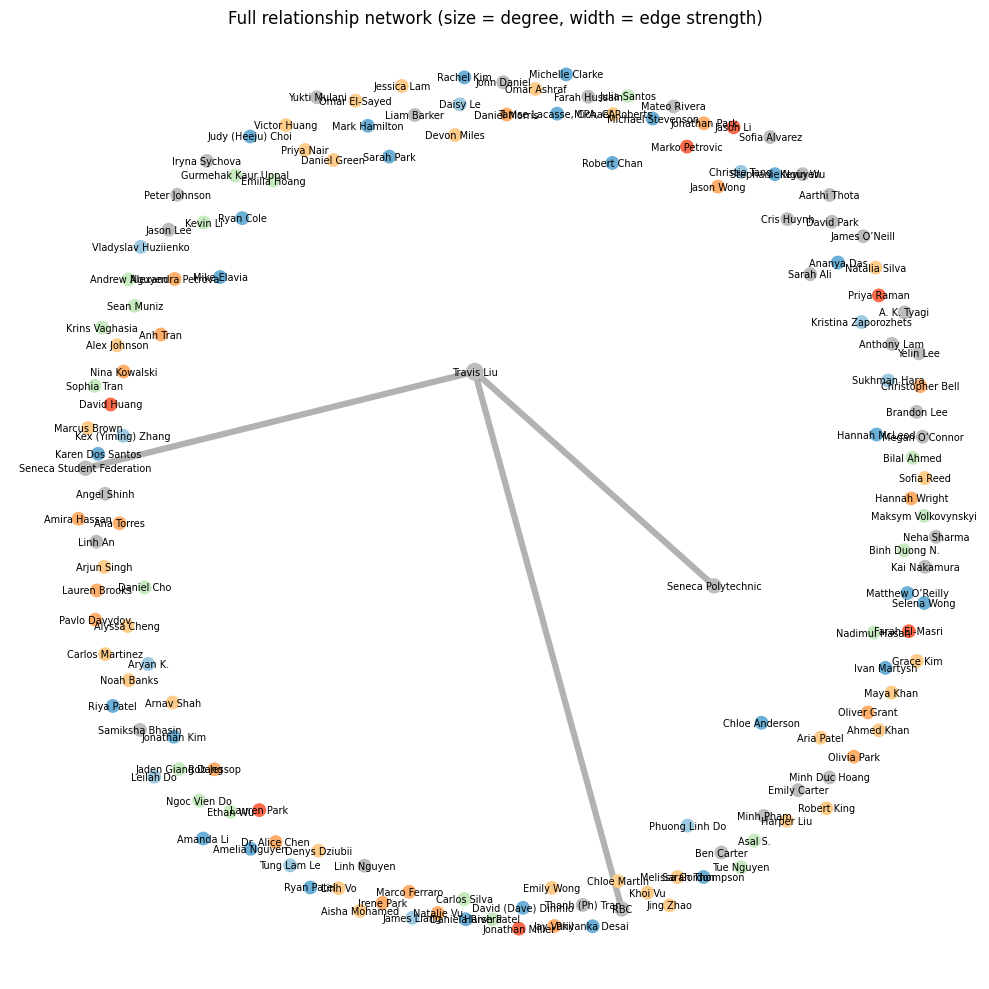

In [33]:
# Layout for the whole graph
pos = nx.spring_layout(G, k=0.8, seed=42)  # tweak k if it’s too cramped

# Node sizes = degree
degrees = dict(G.degree())
node_sizes = [80 + 20 * degrees[n] for n in G.nodes()]

# Node colors = seniority
seniority_palette = {
    "Student/Intern": "#9ecae1",
    "Entry":          "#c7e9c0",
    "Mid":            "#fdcc8a",
    "Senior":         "#fdae6b",
    "Lead/Staff":     "#fb6a4a",
    "Manager+":       "#6baed6",
    "Founder":        "#31a354",
    "Other":          "#bdbdbd",
}
node_colors = [
    seniority_palette.get(G.nodes[n].get("seniority", "Other"), "#bdbdbd")
    for n in G.nodes()
]

# Edge widths = weight (normalized)
weights = [d.get("weight", 1.0) for _, _, d in G.edges(data=True)]
if weights:
    max_w = max(weights)
    edge_widths = [0.5 + 4.0 * (w / max_w) for w in weights]
else:
    edge_widths = 1.0

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: G.nodes[n].get("name", n) for n in G.nodes()},
    font_size=7,
)

plt.title("Full relationship network (size = degree, width = edge strength)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [34]:
edge_rows = []
for u, v, d in G.edges(data=True):
    edge_rows.append({
        "from_id": u,
        "from_name": G.nodes[u].get("name", u),
        "to_id": v,
        "to_name": G.nodes[v].get("name", v),
        "weight": d.get("weight", 1.0),
        "signals": ", ".join(map(str, d.get("signals", d.get("tags", [])))),
    })

edges_df = pd.DataFrame(edge_rows)
edges_df_sorted = edges_df.sort_values("weight", ascending=False)

print("Top 10 strongest edges:")
display(edges_df_sorted.head(10))

print("Top 10 weakest edges:")
display(edges_df_sorted.tail(10))

Top 10 strongest edges:


,from_id,from_name,to_id,to_name,weight,signals
0,travis_liu,Travis Liu,Seneca Polytechnic,Seneca Polytechnic,1.0,"education, former employer"
1,travis_liu,Travis Liu,RBC,RBC,1.0,current employer
2,travis_liu,Travis Liu,Seneca Student Federation,Seneca Student Federation,1.0,"leadership, volunteer"


Top 10 weakest edges:


,from_id,from_name,to_id,to_name,weight,signals
0,travis_liu,Travis Liu,Seneca Polytechnic,Seneca Polytechnic,1.0,"education, former employer"
1,travis_liu,Travis Liu,RBC,RBC,1.0,current employer
2,travis_liu,Travis Liu,Seneca Student Federation,Seneca Student Federation,1.0,"leadership, volunteer"


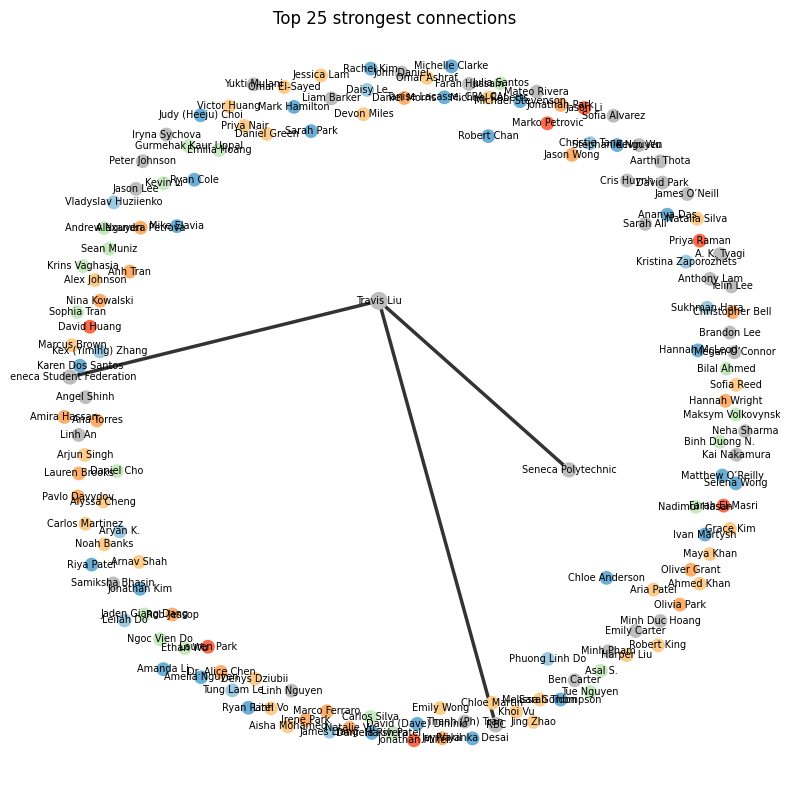

In [35]:
top_k = 25
strong_edges = list(
    zip(
        edges_df_sorted.head(top_k)["from_id"],
        edges_df_sorted.head(top_k)["to_id"],
    )
)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edgelist=strong_edges, width=2.5, alpha=0.8)
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: G.nodes[n].get("name", n) for n in G.nodes()},
    font_size=7,
)
plt.title(f"Top {top_k} strongest connections")
plt.axis("off")
plt.tight_layout()
plt.show()

## Predict the factor by using features

In [36]:
def get_list(x, key):
    v = x.get(key, [])
    return v if isinstance(v, list) else []

rows = []
for p in people:
    pid = p.get("id") or p.get("_id") or p.get("slug") or p.get("name")
    rows.append({
        "id": pid,
        "name": p.get("name", ""),
        "company": p.get("company", ""),
        "role": p.get("role", ""),
        "seniority": p.get("seniority", "Other"),
        "n_schools": len(get_list(p, "schools")),
        "n_skills": len(get_list(p, "skills")),
        "n_keywords": len(get_list(p, "keywords")),
        "n_connections": len(p.get("connections", [])),
    })

df = pd.DataFrame(rows)
df.head()

,id,name,company,role,seniority,n_schools,n_skills,n_keywords,n_connections
0,travis_liu,Travis Liu,RBC,Software Engineer in Test,Other,1,18,5,3
1,kristina_z_16412b2a7,Kristina Zaporozhets,Scotiabank,Global Analytics and Financial Engineer Intern,Student/Intern,1,9,5,0
2,ngoc_vien_do_991273gs1,Ngoc Vien Do,,Software Developer,Entry,1,6,0,0
3,andrewnt219,Andrew Nguyen,KPMG Canada,Software Engineer,Entry,1,10,5,0
4,tanise_lacasse_cpa_ca_5ab67640,"Tanise Lacasse, CPA, CA",KPMG Canada,Partner,Manager+,1,10,5,0


In [37]:
num_cols = ["n_schools", "n_skills", "n_keywords", "n_connections"]
corr = df[num_cols].corr()
corr

,n_schools,n_skills,n_keywords,n_connections
n_schools,1.000000,0.061486,0.146947,0.007276
n_skills,0.061486,1.000000,0.331634,0.440323
n_keywords,0.146947,0.331634,1.000000,0.030935
n_connections,0.007276,0.440323,0.030935,1.000000


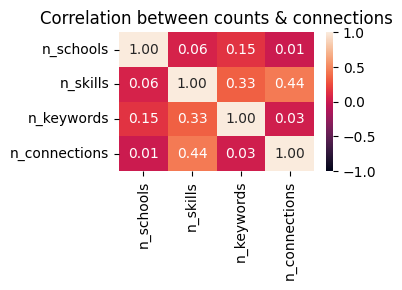

In [38]:
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation between counts & connections")
plt.tight_layout()
plt.show()

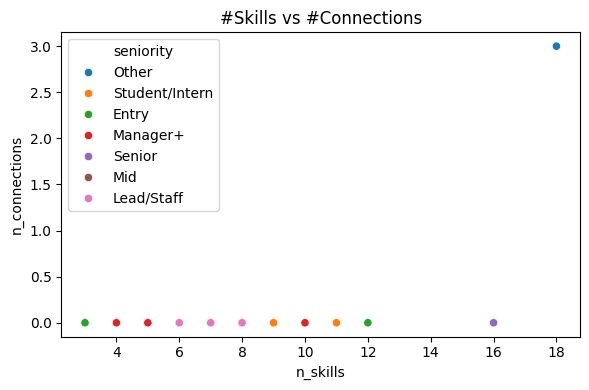

In [39]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="n_skills",
    y="n_connections",
    hue="seniority",
)
plt.title("#Skills vs #Connections")
plt.tight_layout()
plt.show()

## Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

X = df[["n_schools", "n_skills", "n_keywords", "seniority"]]
y = df["n_connections"]

numeric_features = ["n_schools", "n_skills", "n_keywords"]
categorical_features = ["seniority"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("regressor", LinearRegression()),
    ]
)

model.fit(X, y)
y_pred = model.predict(X)

print("R^2 on this dataset:", r2_score(y, y_pred))